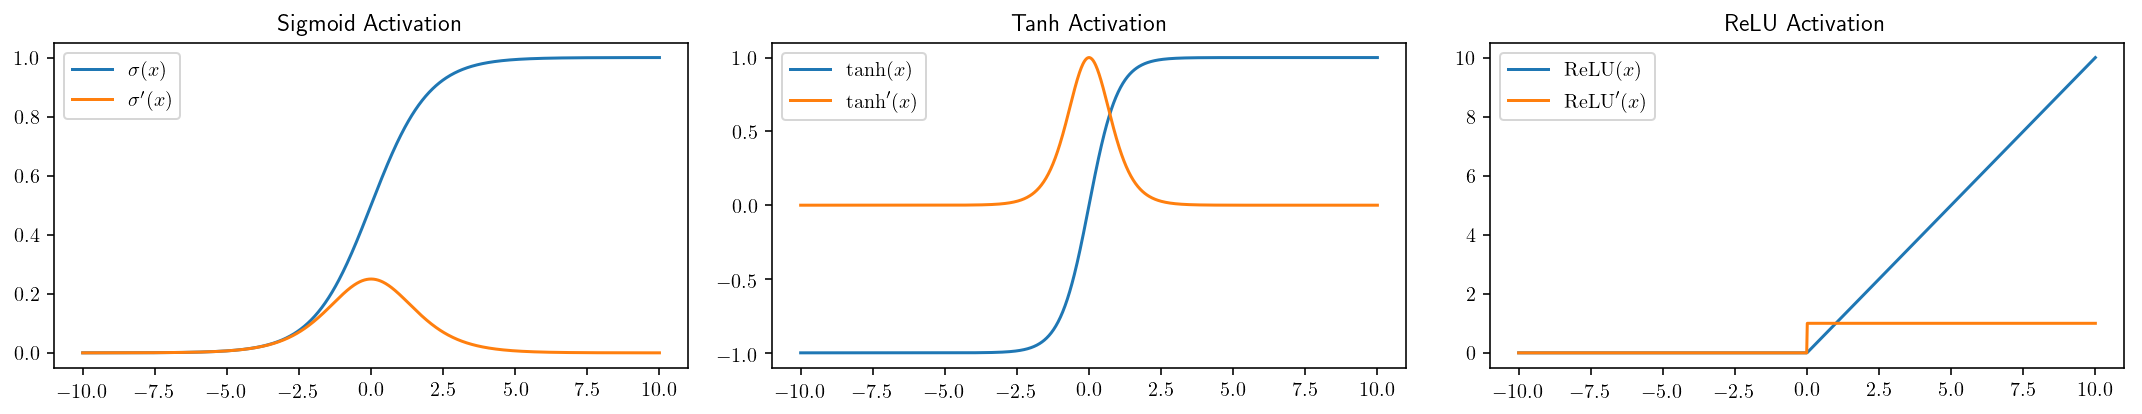

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(-10, 10, 1000)
sigmoid = np.exp(-np.logaddexp(0, -x))
tanh = np.tanh(x)
relu = np.maximum(x, 0)

plt.rcParams.update({'font.sans-serif': 'cmss10', 'text.usetex': True})
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
axes[0].plot(x, sigmoid, label='$\sigma(x)$')
axes[0].plot(x, sigmoid * (1 - sigmoid), label="$\sigma'(x)$")
axes[0].set_title('Sigmoid Activation')
axes[0].legend()

axes[1].plot(x, tanh, label='$\mathrm{tanh}(x)$')
axes[1].plot(x, 1 - tanh ** 2, label="$\mathrm{tanh}'(x)$")
axes[1].set_title('Tanh Activation')
axes[1].legend()

axes[2].plot(x, relu, label='$\mathrm{ReLU}(x)$')
axes[2].plot(x, np.where(x < 0, np.zeros_like(x), np.ones_like(x)), label="$\mathrm{ReLU}'(x)$")
axes[2].set_title('ReLU Activation')
axes[2].legend()
plt.tight_layout()

Before batch normalization was invented, initialization was quite important and challenging. With a lousy initialization, the gradients of deep nets easily explode or vanish, especially with the flat tails of sigmoidal activation functions such as `sigmoid` or `tanh`. We can often perform gradient clipping when the magnitudes of the gradients are too large, but gradient vanishing simply stops the network from learning anything useful. Even with `ReLU`, sloppy initialization can kill a lot neurons by disallowing gradients to flow back through the activation function.

### Xavier Initialization

[Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) proposes an initialization scheme for the `sigmoid` and `tanh` activation functions. The idea is that since we don't want to end up with outputs of large magnitudes after going through any layer, we probably want the variance of its inputs and that of its outputs approximately equal. More specifically, let's assume we have a linear neuron with weight vector $w$ and bias scalar $b$ that spits out a scalar $y$ for an input vector $x$:
\\[ y = w^{\mathsf{T}}x + b = w_1 x_1 + w_2 x_2 + \dots + w_nx_n + b.\\]

For the sake of analysis, suppose that $w_ix_i$ are i.i.d. and that $w_i$ is independent of $x_i$. Then $\text{Var}(y) = \sum \text{Var}(w_ix_i) = n\text{Var}(w_ix_i)$ for some particular $i$. In general, for independent variables $X$ and $Y$,
\\[ \text{Var}(XY) = \mathbb{E}[X^2] \mathbb{E}[Y^2] - (\mathbb{E}[X])^2 (\mathbb{E}[Y])^2 = (\mathbb{E}[X])^2 \text{Var}(Y) + (\mathbb{E}[Y])^2 \text{Var}(X) + \text{Var}(X) \text{Var}(Y).\\]
If both $w_i$ and $x_i$ have mean 0, then $\text{Var}(y) = [n\text{Var}(w_i)]\text{Var}(x_i)$. In other words, the variance of the output is scaled by a factor of $n\text{Var}(w_i)$, which means we should probably set $\text{Var}(w_i) = n^{-1}$ to ensure that the variance remains relatively stable. If a linear layer has $n_{\text{out}}$ neurons, each specified by a weight vector of size $n_{\text{in}}$, then the forward direction wants $\text{Var}(w_i) = n_{\text{in}}^{-1}$ while the backward direction needs $\text{Var}(w_i) = n_{\text{out}}^{-1}$. [Glorot and Bengio (2010)](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) proposes a compromise that uses the harmonic mean of $ n_{\text{in}}^{-1}$ and $n_{\text{out}}^{-1}$:
\\[ \text{Var}(w_i) = \frac{2}{ n_{\text{in}} + n_{\text{out}}}.\\]
With the identified variance for $w_i$, we often choose sample $w_i$ either from a zero-centered normal distribution or a uniform distribution, i.e.
\\[w_i \ \sim \ \mathcal{N}\left(0,  \frac{2}{ n_{\text{in}} + n_{\text{out}}} \right) \quad \text{or} \quad w_i \ \sim \ \mathcal{U}\left(-\sqrt{\frac{6}{ n_{\text{in}} + n_{\text{out}}}}, \sqrt{\frac{6}{ n_{\text{in}} + n_{\text{out}}}} \right).\\]
For a convolutional weight of size $C_{\text{out}} \times C_{\text{in}} \times K \times K$, we let $n_{\text{in}} = K^2C_{\text{in}}$ and $n_{\text{out}} = K^2C_{\text{out}}$.

### Kaiming Initialization

Since the `ReLU` activation function basically zeros out an entire half of the domain, the variance of $y = w^{\mathsf{T}}x + b$ is roughly halved, or roughly speaking, we reduce the number of effective neurons by a factor of 2. [He et al. (2015)](https://arxiv-web3.library.cornell.edu/abs/1502.01852) proposes an initialization scheme that takes into account this factor:
\\[w_i \ \sim \ \mathcal{N}\left(0,  \frac{2}{n_{\text{out}}} \right) \quad \text{or} \quad w_i \ \sim \ \mathcal{U}\left(-\sqrt{\frac{6}{n_{\text{out}}}}, \sqrt{\frac{6}{ n_{\text{out}}}} \right).\\]
Xavier initialization often works best with the `sigmoid` or `tanh` functions, while Kaiming initialization, as motivated, works best with the `ReLU` function.

### Experiment on MNIST

In [1]:
import logging
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import seaborn
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F

from collections import namedtuple, defaultdict
from tqdm import tqdm_notebook as tqdm
from torchvision import datasets, transforms


class Model(nn.Module):
    def __init__(self, num_classes=10, activation_fn=nn.ReLU, init_method=nn.init.kaiming_normal_):
        super().__init__()
        self.add_module('conv1', nn.Conv2d(1, 16, 5, padding=2))
        self.add_module('{}1'.format(activation_fn.__name__.lower()), activation_fn())
        self.add_module('conv2', nn.Conv2d(16, 16, 5, padding=2))
        self.add_module('{}2'.format(activation_fn.__name__.lower()), activation_fn())
        self.add_module('pool1', nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.add_module('conv3', nn.Conv2d(16, 32, 5, padding=2))
        self.add_module('{}3'.format(activation_fn.__name__.lower()), activation_fn())
        self.add_module('conv4', nn.Conv2d(32, 32, 5, padding=2))
        self.add_module('{}4'.format(activation_fn.__name__.lower()), activation_fn())
        self.add_module('pool2', nn.MaxPool2d(kernel_size=2, stride=2))
        self.add_module('fc', nn.Linear(7 * 7 * 32, num_classes))
        self.initialize_weights(init_method)
        
    def initialize_weights(self, init_method):            
        for module in self.modules():
            if isinstance(module, nn.Conv2d):
                init_method(module.weight)
                module.bias.data.zero_()
            elif isinstance(module, nn.Linear):
                init_method(module.weight)
                module.bias.data.zero_()
                
    def forward(self, input, activations=None):
        output = input
        for name, module in list(self.named_modules())[1:]:
            if isinstance(module, nn.Linear):
                output = output.view(output.size(0), -1)
            output = module(output)
            if activations is not None and 'pool' not in name and 'fc' not in name:
                activations[name] = output[0].view(-1).detach().cpu().numpy()
        return output
    
    
def train(args):
    # Reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    logging.basicConfig(stream=sys.stdout, format='[%(asctime)s] %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

    # Load datasets
    train_loader, valid_loader = load_mnist(args)

    # Build a model
    model = Model(args.num_classes, args.activation_fn, args.init_method).cuda()
    logging.info('Built a model consisting of {:,} parameters with {} activation and {} initialization'.format(
        sum(p.numel() for p in model.parameters()), args.activation_fn.__name__.lower(), args.init_method.__name__))

    # Build an optimizer
    optimizer = torch.optim.Adam(model.parameters(), args.lr)
    train_stats, valid_stats, best_score = [], [], 0
    act_hist, param_hist, grad_hist = [], [], []
        
    for epoch in range(args.max_epoch):
        model.train()
        train_loss, train_accuracy, count = 0., 0., 0
        progress_bar = tqdm(train_loader, desc='| Epoch {:03d}'.format(epoch), leave=False)

        activations, parameters, gradients = {}, {}, {}
        for batch_id, sample in enumerate(progress_bar):
            input, target = sample[0].cuda(), sample[1].cuda()
            output = model(input, activations=activations if batch_id == 0 else None)
            loss = F.cross_entropy(output, target)
            pred = output.max(1, keepdim=True)[1]
            accuracy = 100 * pred.eq(target.view_as(pred)).sum().float() / len(input)

            optimizer.zero_grad()
            loss.backward()
            if batch_id == 0:
                for tag, value in model.named_parameters():
                    if 'weight' not in tag or 'fc' in tag: continue
                    parameters[tag.split('.')[0]] = value.view(-1).detach().cpu().numpy()
                    gradients[tag.split('.')[0]] = value.grad.view(-1).detach().cpu().numpy()
                act_hist.append(activations)
                param_hist.append(parameters)
                grad_hist.append(gradients)
            optimizer.step()

            count += len(input)
            train_loss += len(input) * loss.item()
            train_accuracy += len(input) * accuracy.item()
            stats = {'loss': train_loss / count, 'accuracy': train_accuracy / count, 'lr': optimizer.param_groups[0]['lr']}
            progress_bar.set_postfix({key: '{:.4g}'.format(value) for key, value in stats.items()}, refresh=True)

        train_loss, train_accuracy = train_loss / count, train_accuracy / count
        train_stats.append((train_loss, train_accuracy))
        valid_loss, valid_accuracy = validate(args, model, valid_loader, epoch)
        valid_stats.append((valid_loss, valid_accuracy))
        best_score = max(best_score, valid_accuracy)

    logging.info('Done training! Best validation accuracy {}.'.format(best_score))
    return train_stats, valid_stats, act_hist, param_hist, grad_hist
            
            
def validate(args, model, valid_loader, epoch):
    model.eval()
    valid_loss, valid_accuracy, count = 0., 0., 0
    progress_bar = tqdm(valid_loader, desc='| Epoch {:03d}'.format(epoch), leave=False)

    for batch_id, sample in enumerate(progress_bar):
        input, target = sample[0].cuda(), sample[1].cuda()
        output = model(input)
        loss = F.cross_entropy(output, target)
        pred = output.max(1, keepdim=True)[1]
        accuracy = 100 * pred.eq(target.view_as(pred)).sum().float() / len(input)

        count += len(input)
        valid_loss += len(input) * loss.item()
        valid_accuracy += len(input) * accuracy.item()
        stats = {'valid_loss': valid_loss / count, 'valid_accuracy': valid_accuracy / count}
        progress_bar.set_postfix({key: '{:.4g}'.format(value) for key, value in stats.items()}, refresh=True)

    valid_loss, valid_accuracy = valid_loss / count, valid_accuracy / count
    return valid_loss, valid_accuracy

    
def load_mnist(args):
    # Load train dataset
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=args.data, download=not os.path.exists(args.data), train=True, transform=transforms.ToTensor()),
        shuffle=True, batch_size=args.batch_size, num_workers=args.num_workers,
    )
    # Load validation dataset
    valid_loader = torch.utils.data.DataLoader(
        datasets.MNIST(root=args.data, download=not os.path.exists(args.data), train=False, transform=transforms.ToTensor()),
        shuffle=False, batch_size=args.batch_size, num_workers=args.num_workers,
    )
    return train_loader, valid_loader


base_args = {
    'seed': 42, 'data': '/tmp/mnist', 'num_classes': 10, 'batch_size': 100, 'num_workers': 1, 'max_epoch': 10, 'lr': 1e-4,
    'activation_fn': nn.Sigmoid, 'init_method': nn.init.normal_,
}

# Sigmoid activation and standard normal initialization
sst_args = namedtuple('Arguments', base_args.keys())(*base_args.values())
sst_train_stats, sst_valid_stats, sst_act_hist, sst_param_hist, sst_grad_hist = train(sst_args)

# Sigmoid activation and standard scaled normal initialization
ssn_args = dict(base_args, activation_fn=nn.Sigmoid, init_method=lambda x: 0.001 * nn.init.normal_(x))
ssn_args = namedtuple('Arguments', ssn_args.keys())(*ssn_args.values())
ssn_train_stats, ssn_valid_stats, ssn_act_hist, ssn_param_hist, ssn_grad_hist = train(ssn_args)

# Sigmoid activation and Xavier uniform initialization
sxu_args = dict(base_args, activation_fn=nn.Sigmoid, init_method=nn.init.xavier_uniform_)
sxu_args = namedtuple('Arguments', sxu_args.keys())(*sxu_args.values())
sxu_train_stats, sxu_valid_stats, sxu_act_hist, sxu_param_hist, sxu_grad_hist = train(sxu_args)

# Sigmoid activation and Xavier normal initialization
sxn_args = dict(base_args, activation_fn=nn.Sigmoid, init_method=nn.init.xavier_normal_)
sxn_args = namedtuple('Arguments', sxn_args.keys())(*sxn_args.values())
sxn_train_stats, sxn_valid_stats, sxn_act_hist, sxn_param_hist, sxn_grad_hist = train(sxn_args)

# ReLU activation and Xavier normal initialization
rxn_args = dict(base_args, activation_fn=nn.ReLU, init_method=nn.init.xavier_uniform_)
rxn_args = namedtuple('Arguments', rxn_args.keys())(*rxn_args.values())
rxn_train_stats, rxn_valid_stats, rxn_act_hist, rxn_param_hist, rxn_grad_hist = train(rxn_args)

# ReLU activation and Kaiming uniform initialization
rku_args = dict(base_args, activation_fn=nn.ReLU, init_method=nn.init.kaiming_uniform_)
rku_args = namedtuple('Arguments', rku_args.keys())(*rku_args.values())
rku_train_stats, rku_valid_stats, rku_act_hist, rku_param_hist, rku_grad_hist = train(rku_args)

# ReLU activation and Kaiming normal initialization
rkn_args = dict(base_args, activation_fn=nn.ReLU, init_method=nn.init.kaiming_normal_)
rkn_args = namedtuple('Arguments', rkn_args.keys())(*rkn_args.values())
rkn_train_stats, rkn_valid_stats, rkn_act_hist, rkn_param_hist, rkn_grad_hist = train(rkn_args)

[2019-04-10 22:13:46] Built a model consisting of 60,986 parameters with sigmoid activation and normal_ initialization
[2019-04-10 22:15:06] Done training! Best validation accuracy 80.55.
[2019-04-10 22:15:06] Built a model consisting of 60,986 parameters with sigmoid activation and <lambda> initialization
[2019-04-10 22:16:26] Done training! Best validation accuracy 80.55.
[2019-04-10 22:16:26] Built a model consisting of 60,986 parameters with sigmoid activation and xavier_uniform_ initialization
[2019-04-10 22:17:53] Done training! Best validation accuracy 96.21.
[2019-04-10 22:17:53] Built a model consisting of 60,986 parameters with sigmoid activation and xavier_normal_ initialization
[2019-04-10 22:19:21] Done training! Best validation accuracy 96.31.
[2019-04-10 22:19:21] Built a model consisting of 60,986 parameters with relu activation and xavier_uniform_ initialization
[2019-04-10 22:20:48] Done training! Best validation accuracy 98.8.
[2019-04-10 22:20:48] Built a model cons

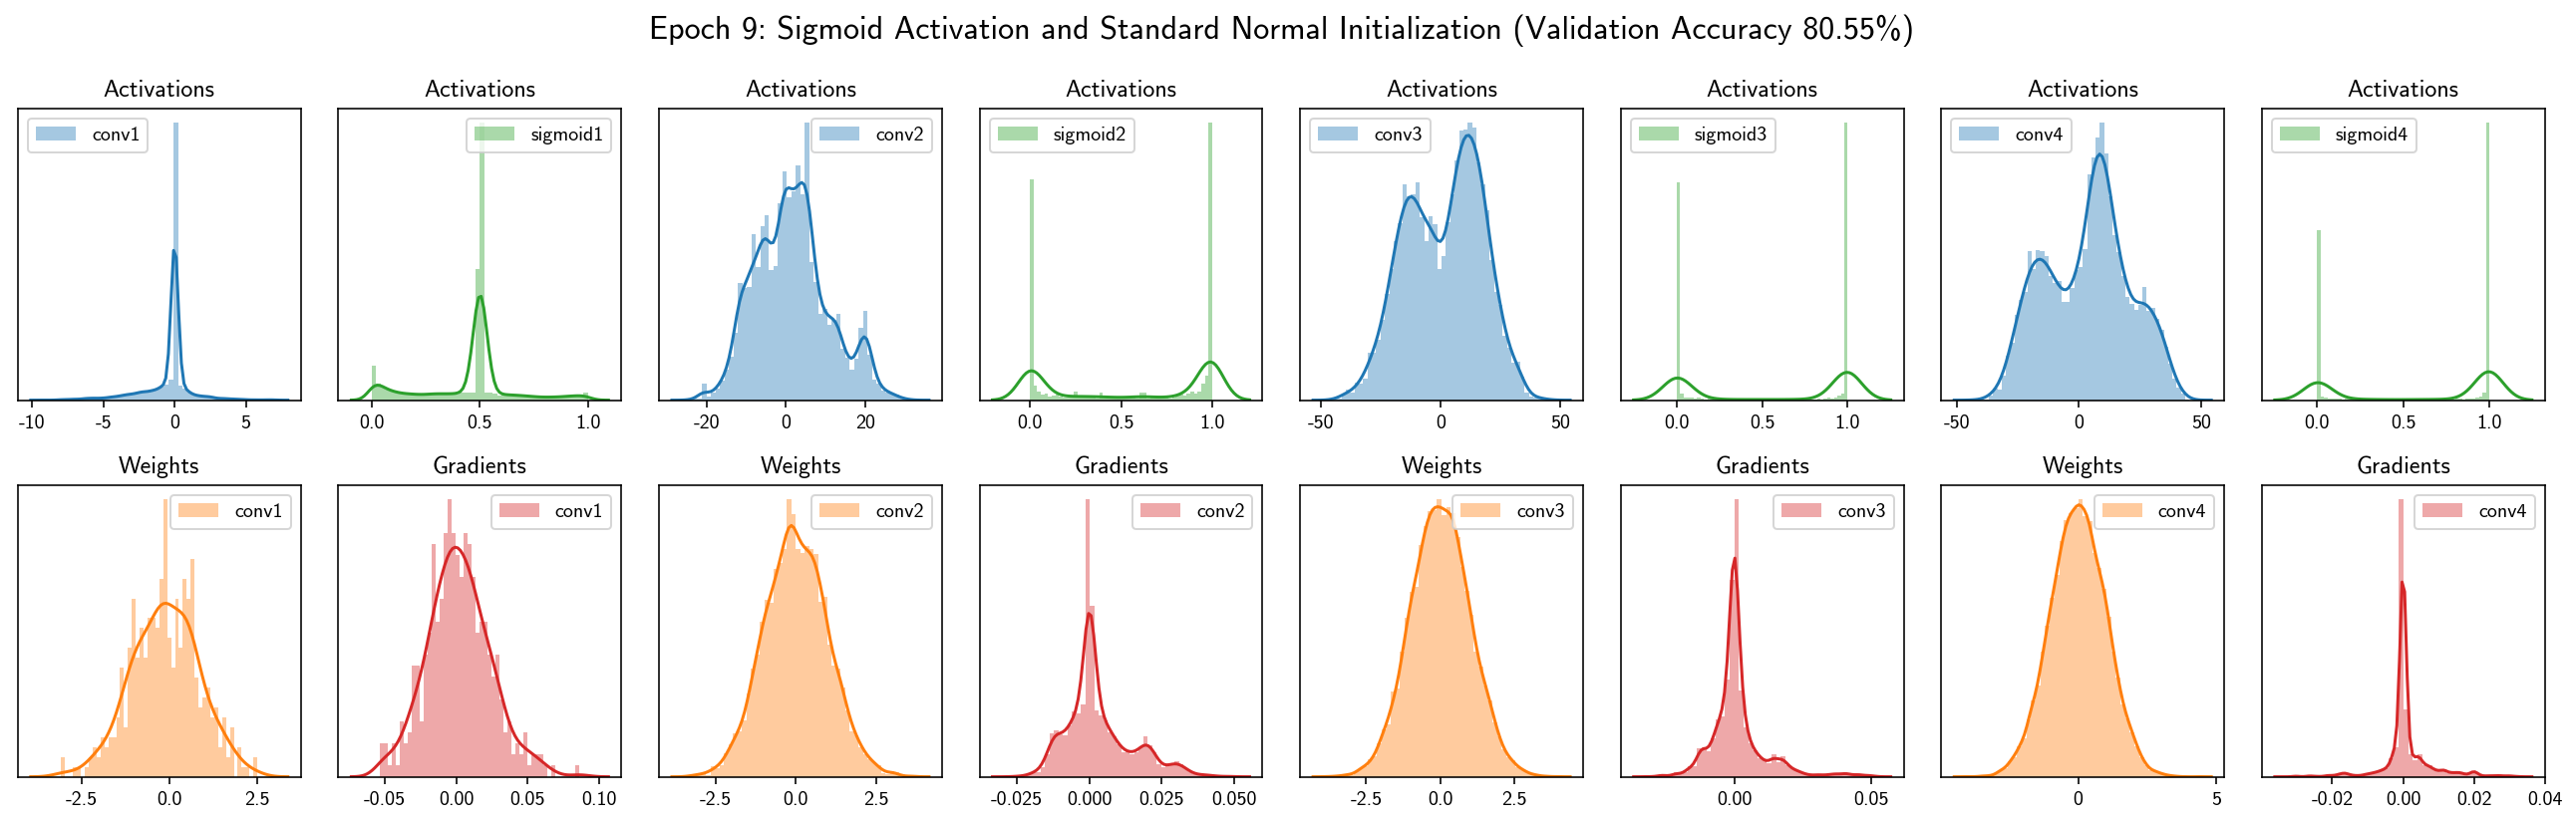

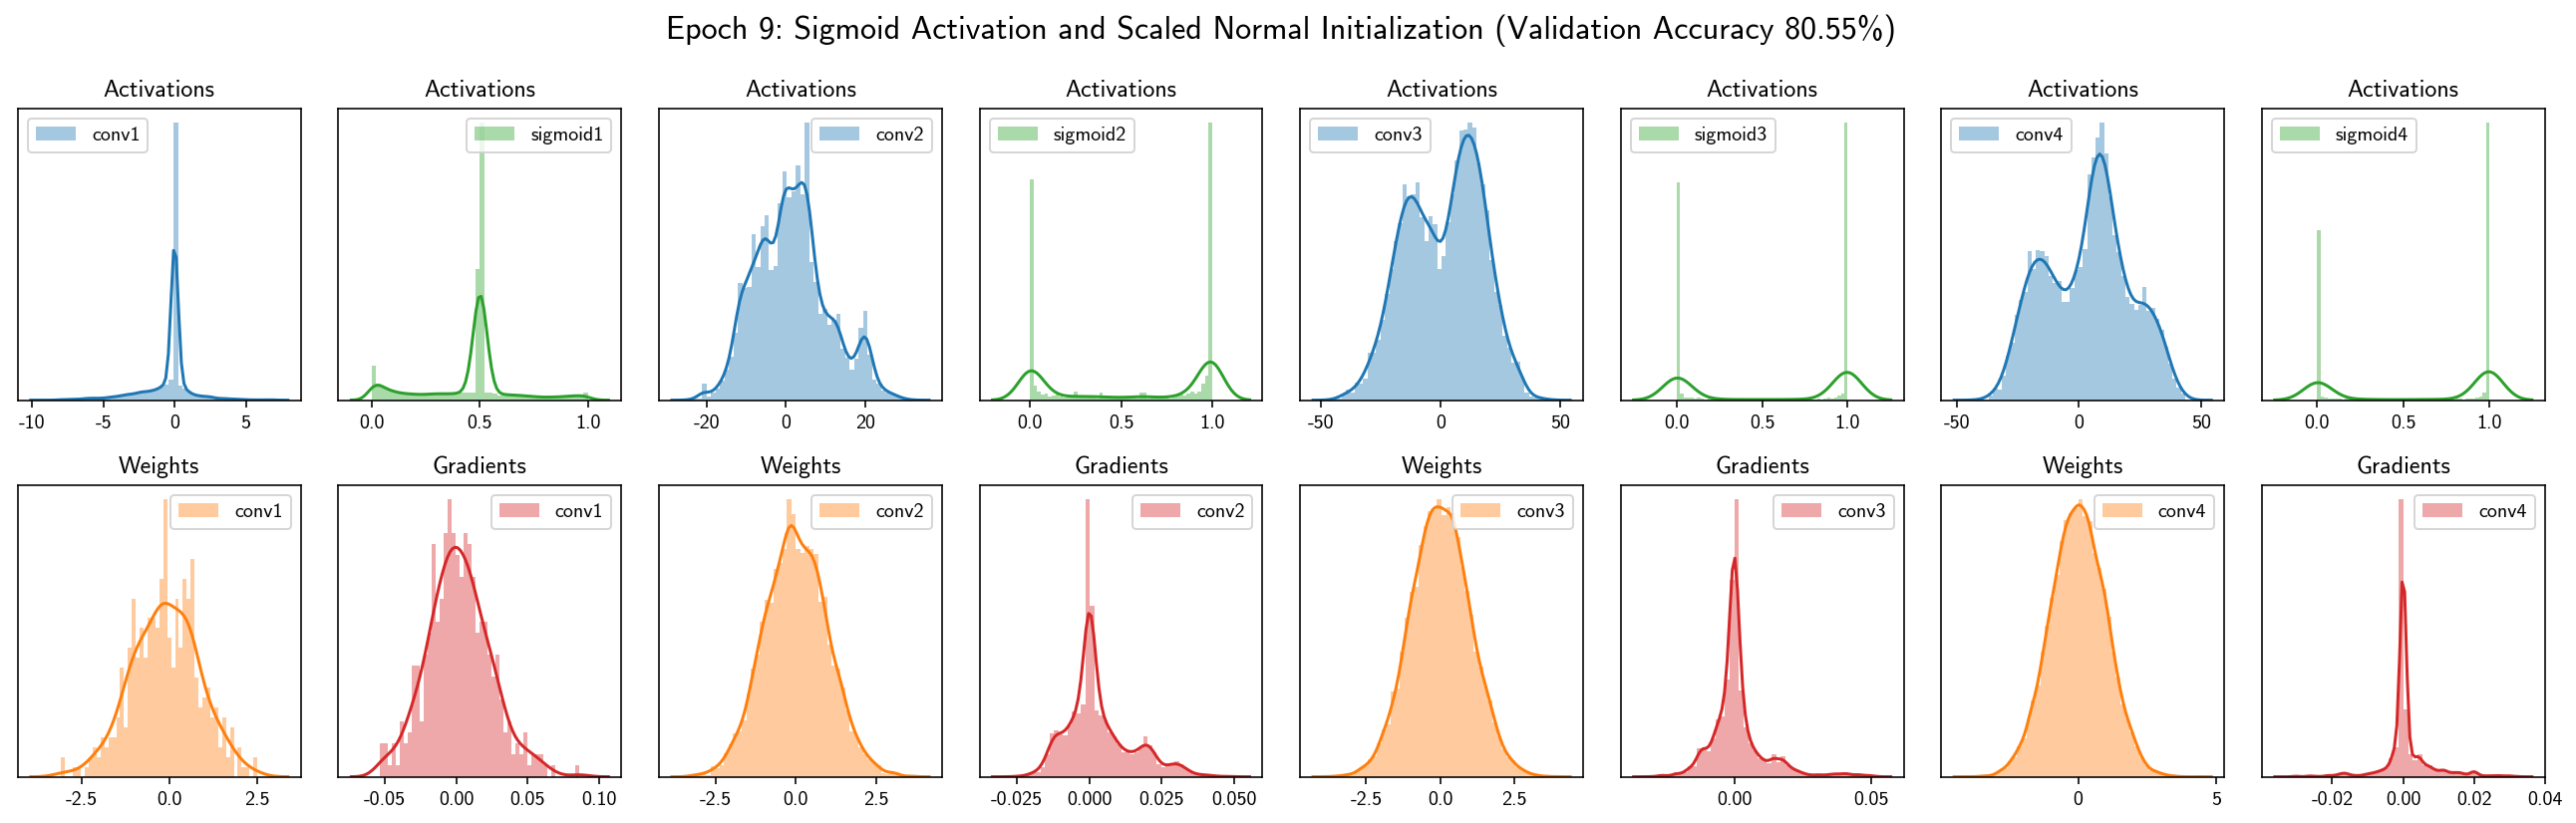

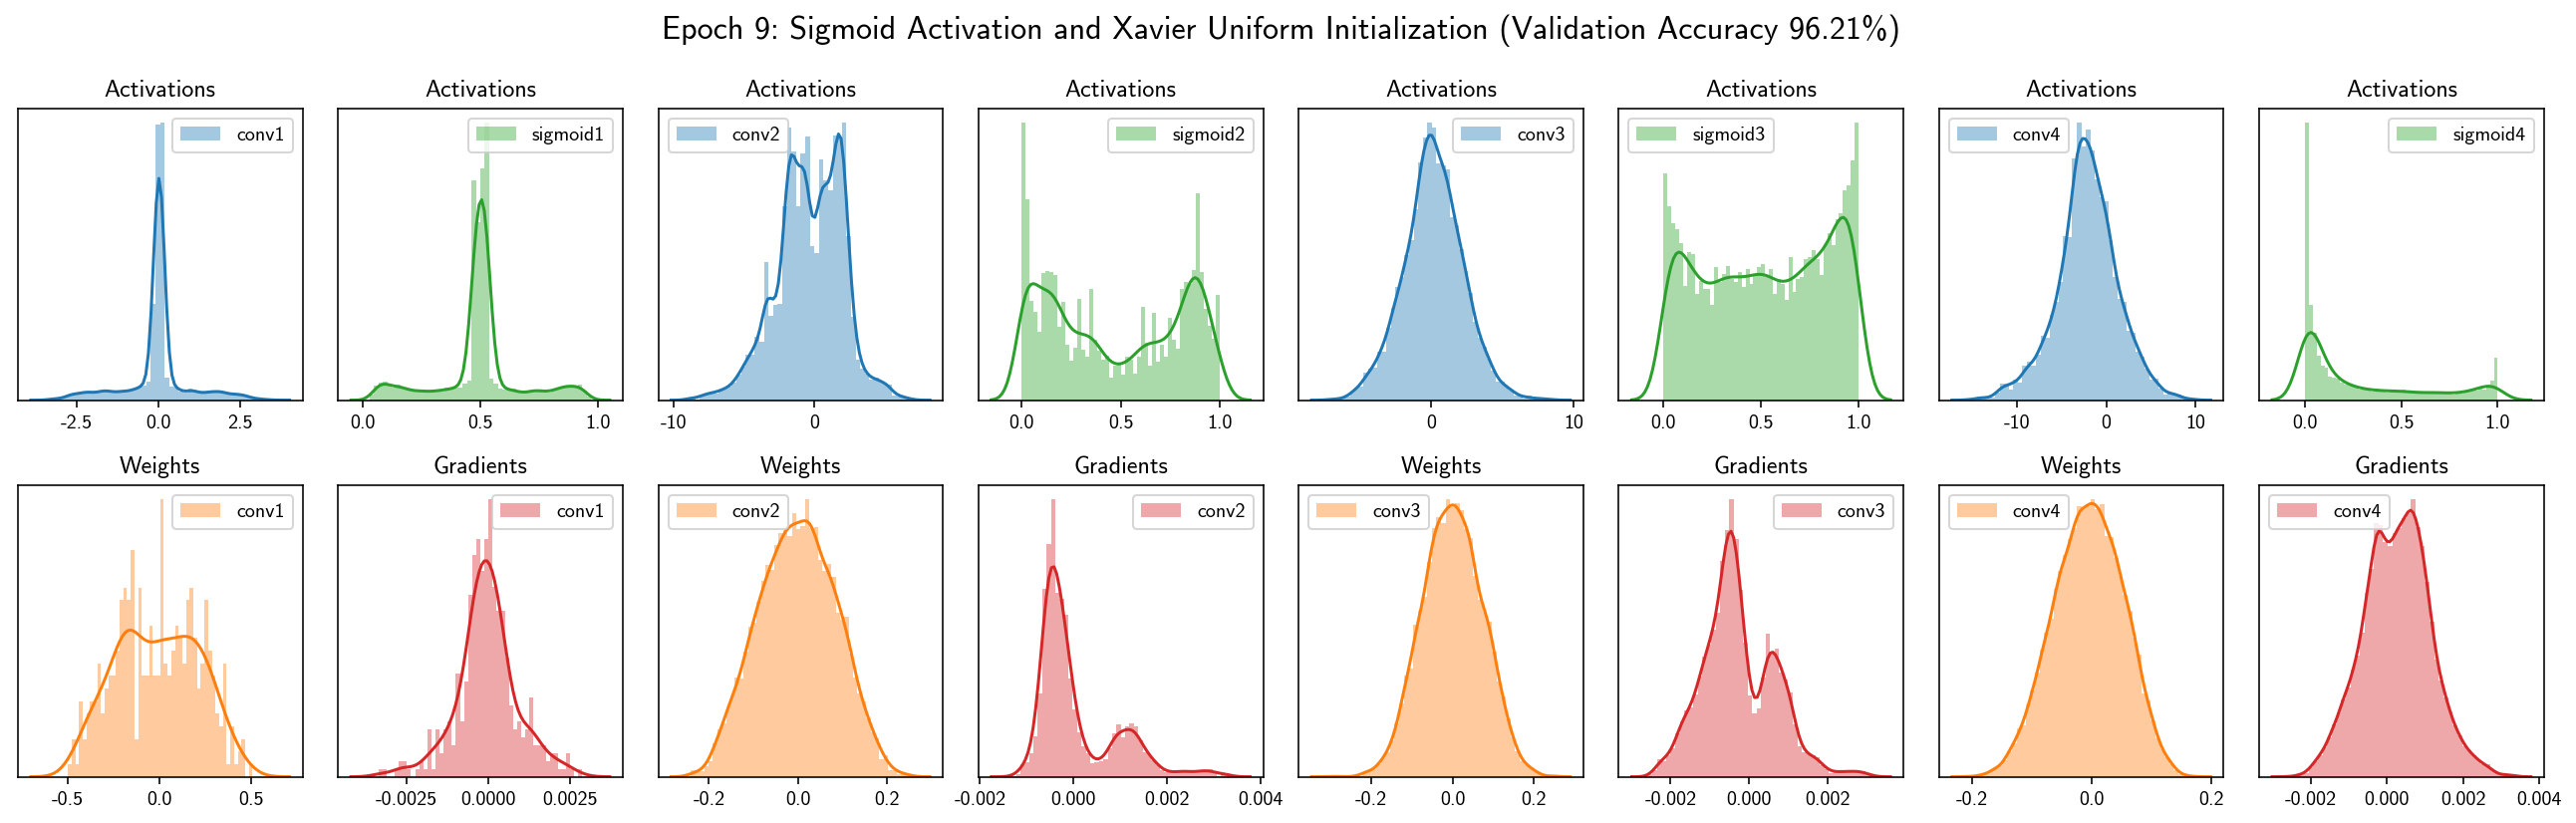

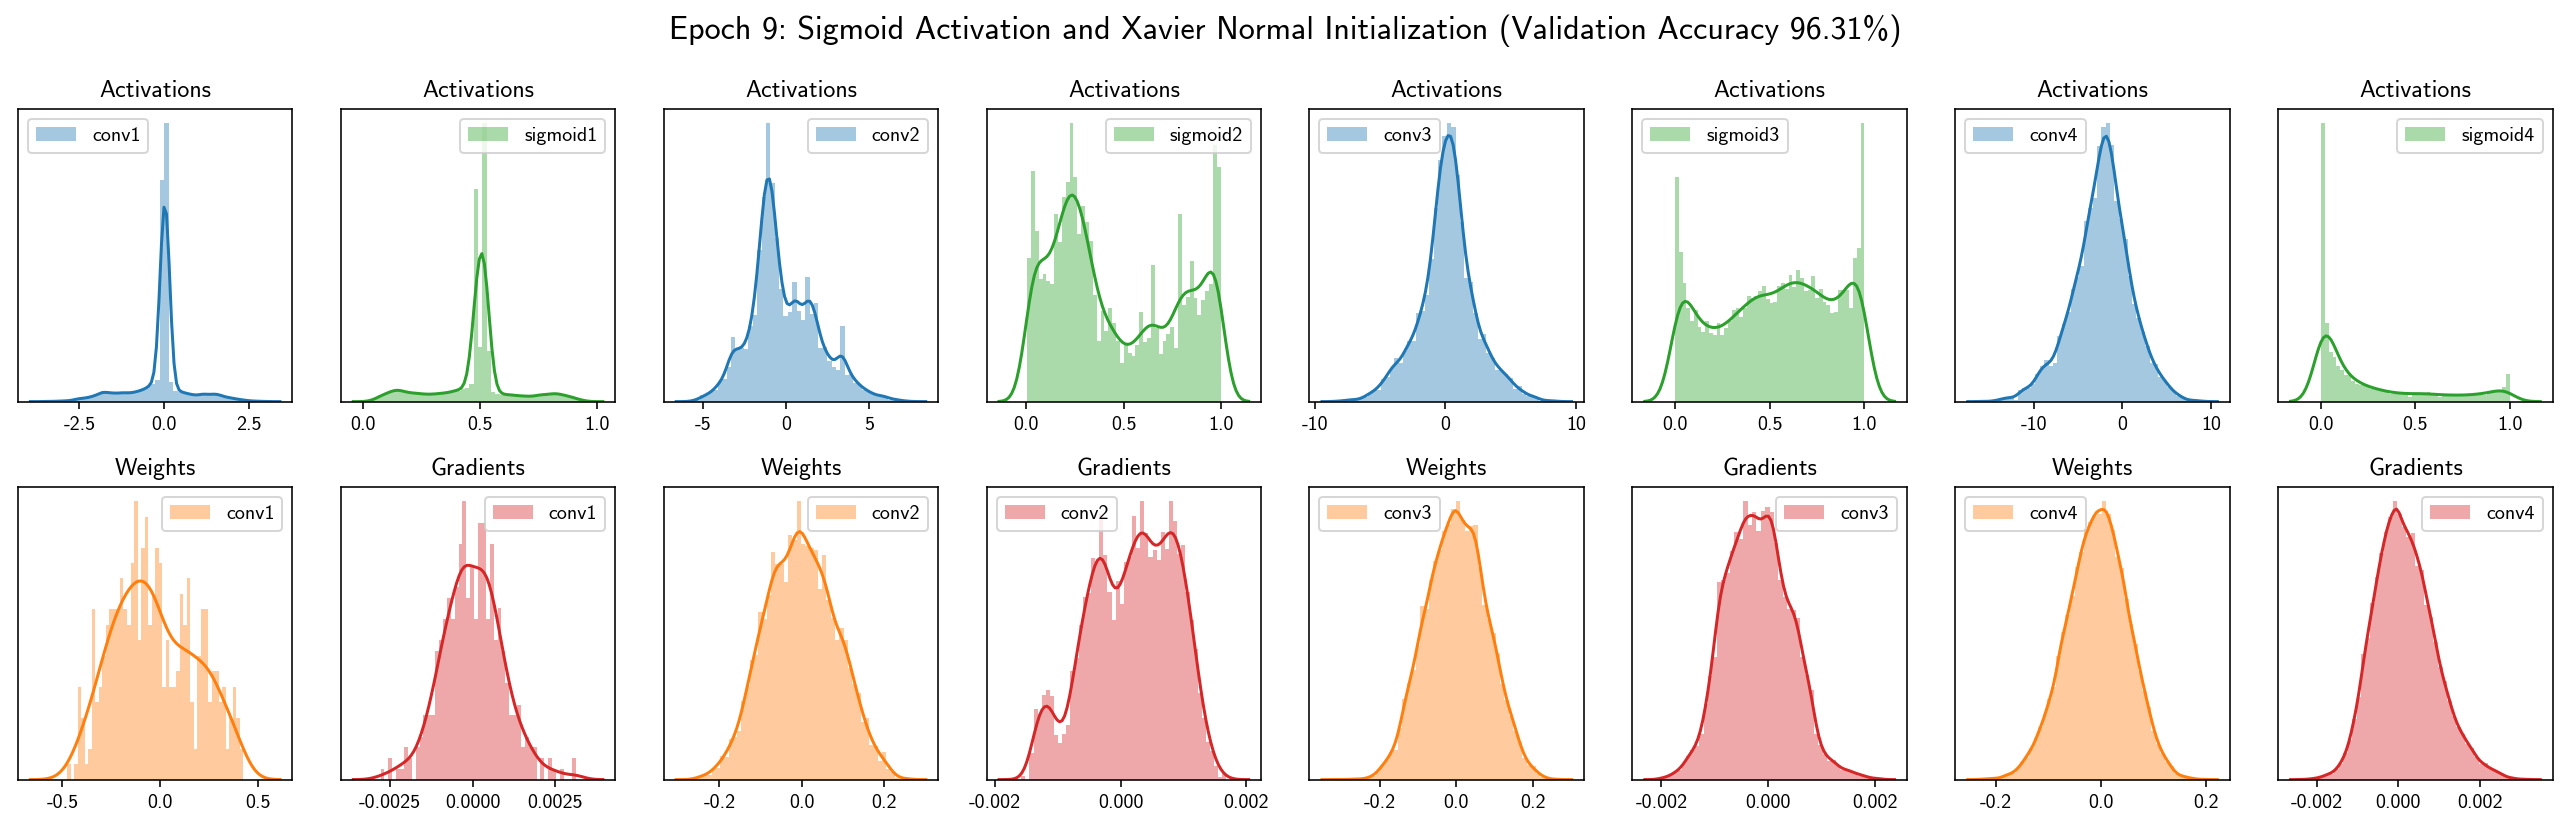

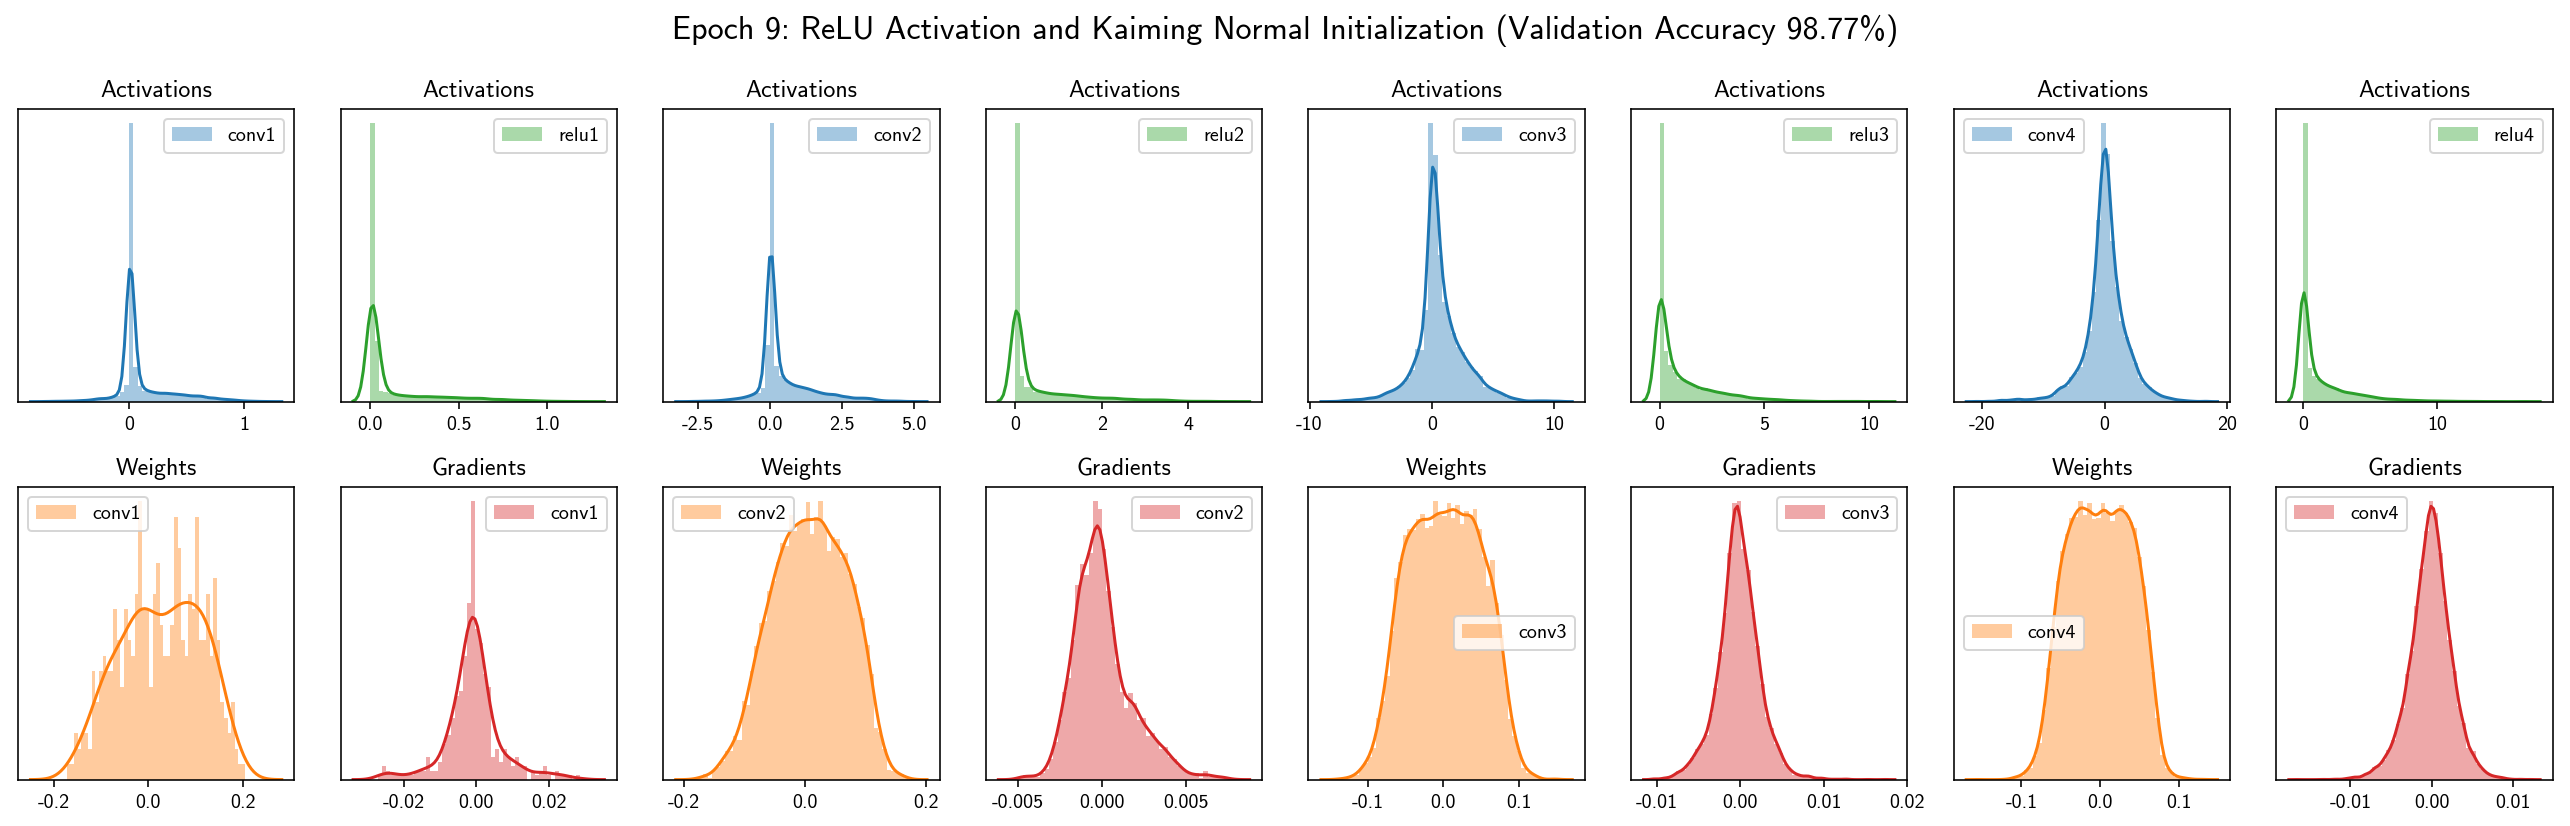

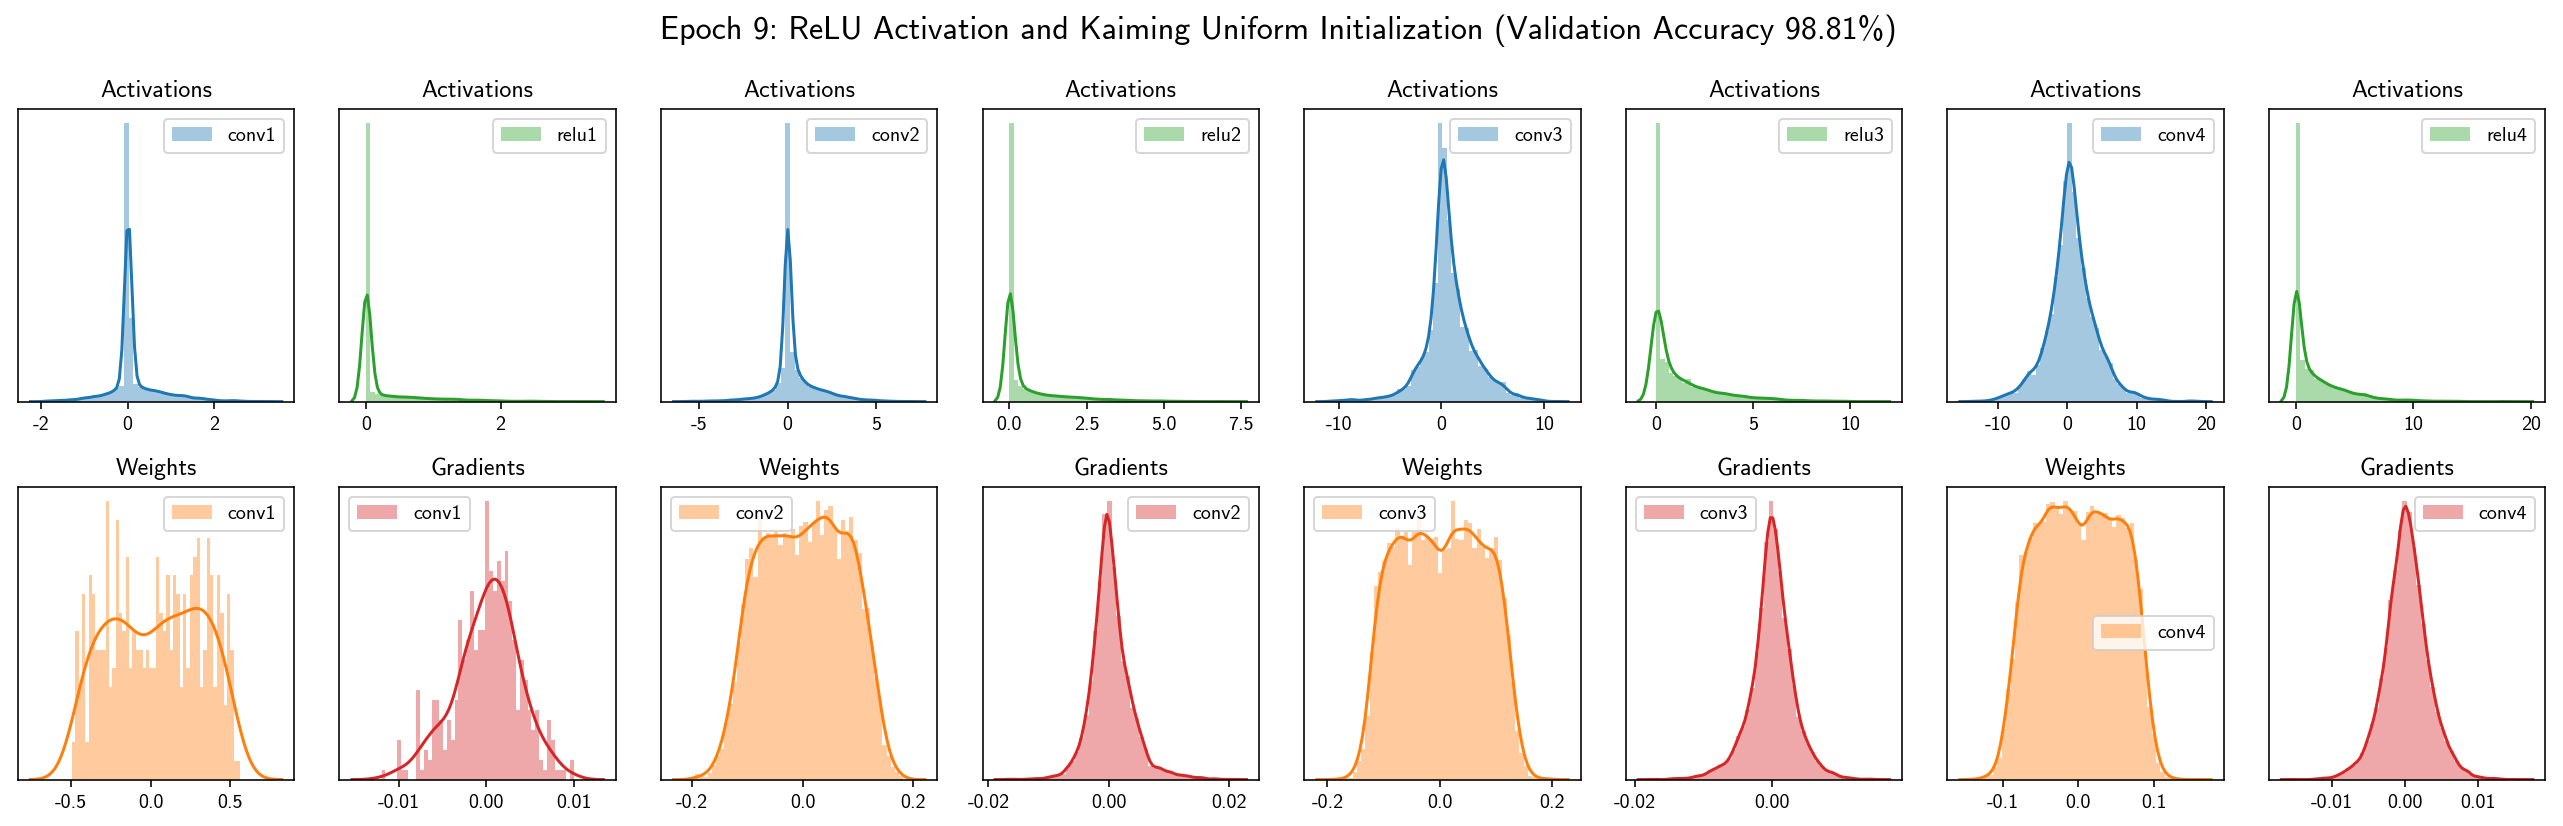

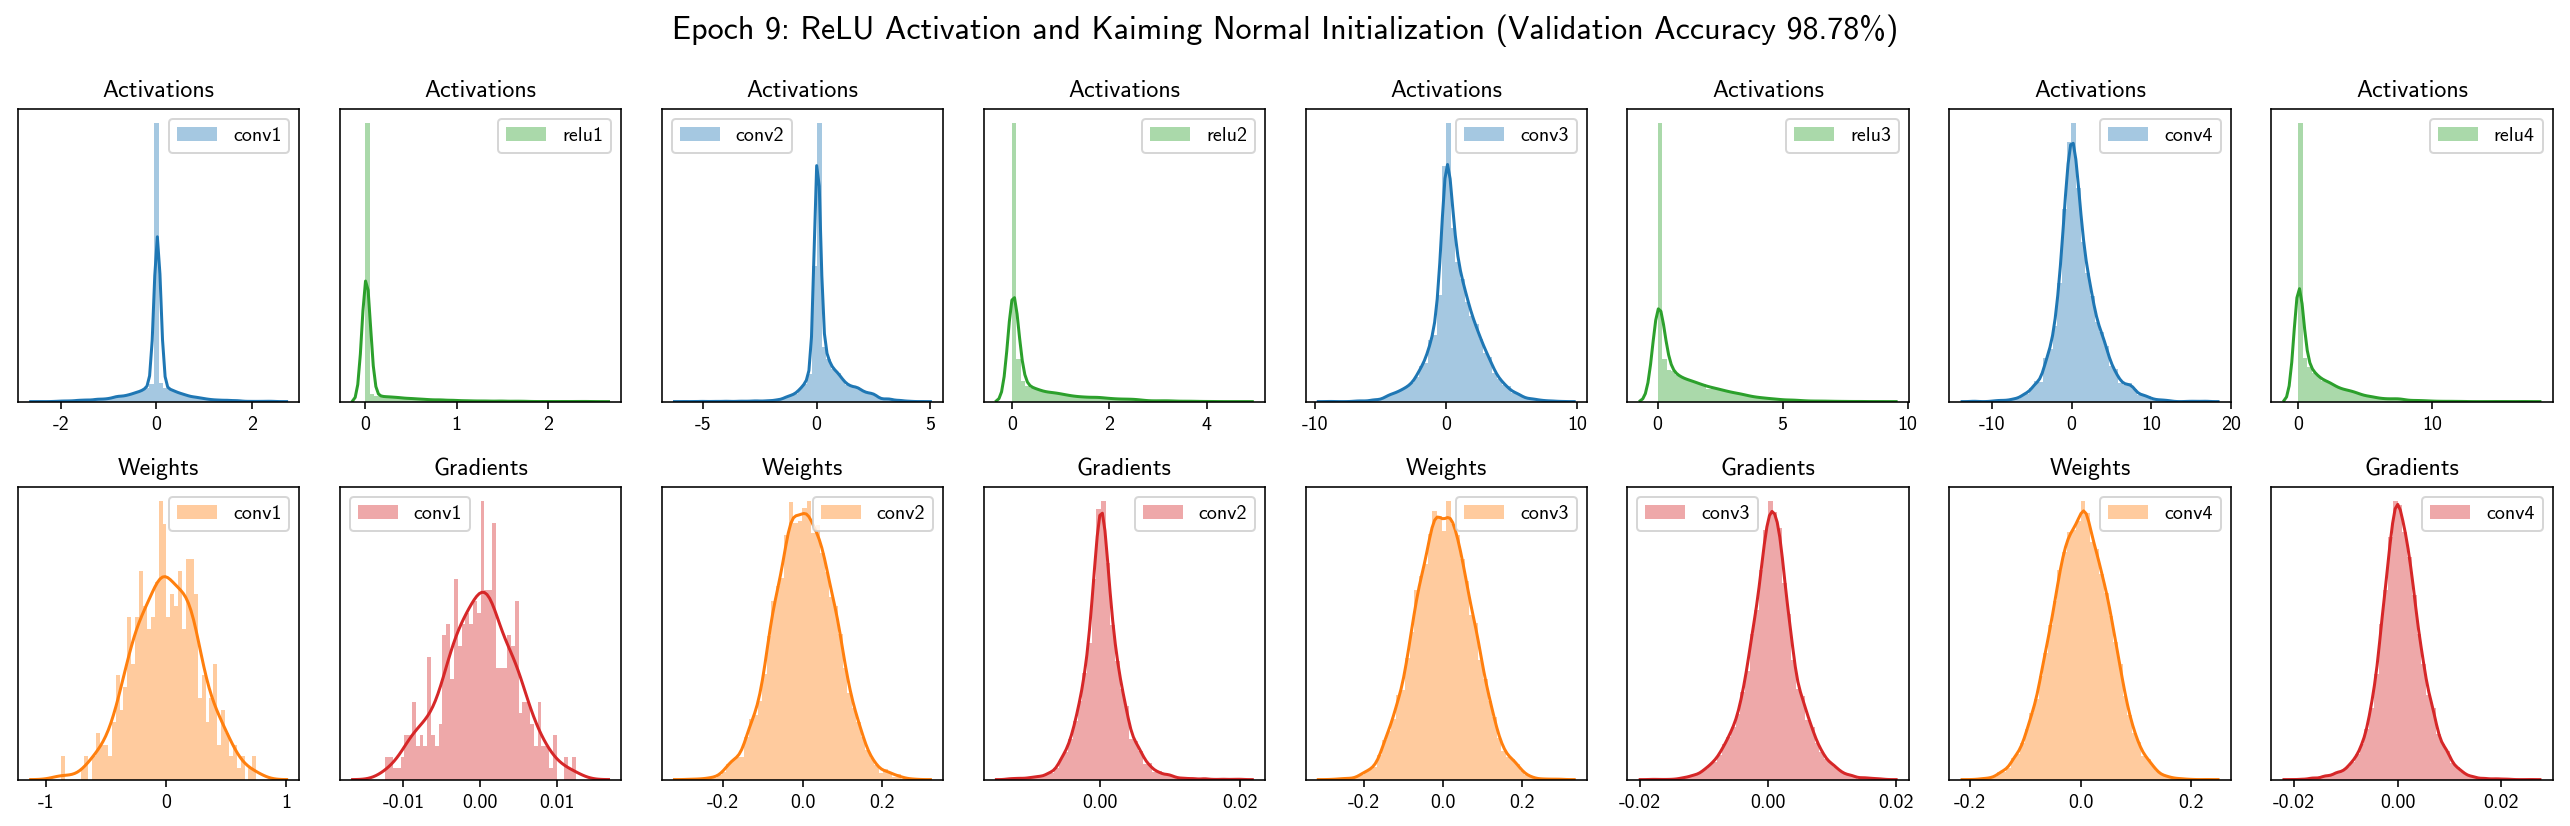

In [47]:
for acronym, act_fn, init in [
    ('sst', 'Sigmoid', 'Standard Normal'), ('ssn', 'Sigmoid', 'Scaled Normal'), ('sxu', 'Sigmoid', 'Xavier Uniform'),
    ('sxn', 'Sigmoid', 'Xavier Normal'), ('rxn', 'ReLU', 'Kaiming Normal'), ('rku', 'ReLU', 'Kaiming Uniform'),
    ('rkn', 'ReLU', 'Kaiming Normal')
]:
    act_hist = eval('{}_act_hist'.format(acronym))
    param_hist = eval('{}_param_hist'.format(acronym))
    grad_hist = eval('{}_grad_hist'.format(acronym))
    valid_stats = eval('{}_valid_stats'.format(acronym))
    
    epoch = len(act_hist) - 1
    fig, axes = plt.subplots(2, 8, figsize=(18, 6))
    plt.suptitle('Epoch {}: {} Activation and {} Initialization (Validation Accuracy {}%)'.format(epoch, act_fn, init, valid_stats[epoch][1]), fontsize=16)

    for idx, (name, values) in enumerate(act_hist[epoch].items()):
        color = 'C0' if 'conv' in name else 'C2'
        seaborn.distplot(values, ax=axes[0][idx], bins=50, color=color, label=name)
        axes[0][idx].set_title('Activations')
        axes[0][idx].legend()
        axes[0][idx].set_yticks([])

    for idx, (name, values) in enumerate(param_hist[epoch].items()):
        seaborn.distplot(values, ax=axes[1][2 * idx], bins=50, color='C1', label=name)
        axes[1][2 * idx].set_title('Weights')
        axes[1][2 * idx].legend()
        axes[1][2 * idx].set_yticks([])

    for idx, (name, values) in enumerate(grad_hist[epoch].items()):
        seaborn.distplot(values, ax=axes[1][2 * idx + 1], bins=50, color='C3', label=name)
        axes[1][2 * idx + 1].set_title('Gradients')
        axes[1][2 * idx + 1].legend()
        axes[1][2 * idx + 1].set_yticks([])

    fig.tight_layout(rect=[0, 0.03, 1, 0.93])
    plt.show()

In [2]:
from IPython.core.display import HTML
HTML(open('../css/custom.css', 'r').read())